In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
%matplotlib inline

In [2]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [3]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [101]:
def fit_and_plot_a_country(country, p0_log =[5,20,40000], p0_exp = [0.5,0.5,0.5], cases = True ):
    if cases :
        try:
            df = pd.read_csv("https://covid.ourworldindata.org/data/total_cases.csv")
        except Exception as e:
            print("Data could not be fetched")
            print(e)
    else:
        # if cases is false, data calculated will be related to deaths
        try:
            df = pd.read_csv("https://covid.ourworldindata.org/data/total_deaths.csv")
        except Exception as e:
            print("Data could not be fetched")
            print(e)
    df = df[['date',country]]
    df = df[True != df[country].isna()]
    df['date'] = df['date'].map(lambda x : (datetime.strptime(x, '%Y-%m-%d') - datetime.strptime("2020-01-01", '%Y-%m-%d')).days)
    x = list(df.iloc[:,0])
    y = list(df.iloc[:,1])
    if country == 'World':
        plt.plot(df.iloc[:,0], df.iloc[:,1],label="Real data",color="red", linestyle = 'dashed')
        plt.ylabel("Amount of infected people")
        plt.xlabel("Days from 1 January 2020")
        return None
    fit = curve_fit(logistic_model,x,y,p0=p0_log, maxfev=2000)
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    a,b,c = fit[0]
    sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    print("Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): ")
    print("a = ", fit[0][0], " +/- ", errors[0])
    print("b = ", fit[0][1], " +/- ", errors[1])
    print("c = ", fit[0][2], " +/- ", errors[2] , "(This also means the amount of cases at the end.)" )
    first_day = datetime.strptime("2020-01-01", '%Y-%m-%d')
    last_day = first_day + timedelta(days=sol)
    last_day = datetime.strftime(last_day,'%Y-%m-%d')
    if cases:
        print("Last day of infections : ", last_day , " (approximately)")
    exp_fit = curve_fit(exponential_model,x,y,p0=p0_exp)
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Actual DATA
    plt.scatter(df.iloc[:,0], df.iloc[:,1],label="Actual data", color="#2554C7")
    # Predicted DATA with logistic model
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic curve", alpha = 0.7, color="green")
    # Predicted DATA with exponential model
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential curve",alpha=0.6, color = "red")
    plt.legend()
    plt.xlabel("Days from 1 January 2020")
    if cases:
        plt.ylabel("Amount of infected people")
    else:
        plt.ylabel("Amount of deaths")   
    plt.ylim((min(y)*0.9,c*1.1))
    plt.show()
    return None
    

In [6]:
for i in pd.read_csv("https://covid.ourworldindata.org/data/total_cases.csv").columns:
    print(i)

date
World
Afghanistan
Albania
Algeria
Andorra
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei
Bulgaria
Burkina Faso
Cambodia
Cameroon
Canada
Cayman Islands
Central African Republic
Chile
China
Colombia
Congo
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Curacao
Cyprus
Czech Republic
Democratic Republic of Congo
Denmark
Dominican Republic
Ecuador
Egypt
Equatorial Guinea
Estonia
Ethiopia
Faeroe Islands
Finland
France
French Guiana
French Polynesia
Gabon
Georgia
Germany
Ghana
Gibraltar
Greece
Guadeloupe
Guernsey
Guinea
Guyana
Honduras
Hungary
Iceland
India
Indonesia
International
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Kuwait
Latvia
Lebanon
Liechtenstein
Lithuania
Luxembourg
Macedonia
Malaysia
Maldives
Malta
Martinique
Mauritania
Mayotte
Mexico
Moldova
Monaco
Mongolia
Morocco
Namibia
Nepal
Netherlands
New Zealand
Nigeria
Norway
Oman
Pakistan
Palestine
Pana

Logistic model coefficients (c / (1 + exp(-( x - b) / a)) ): 
a =  2.619111279977342  +/-  0.06867622426376166
b =  77.44083413558542  +/-  0.7291517883578049
c =  27160.54707524688  +/-  5335.339611160568 (This also means the amount of cases at the end.)
Last day of infections :  2020-04-15  (approximately)


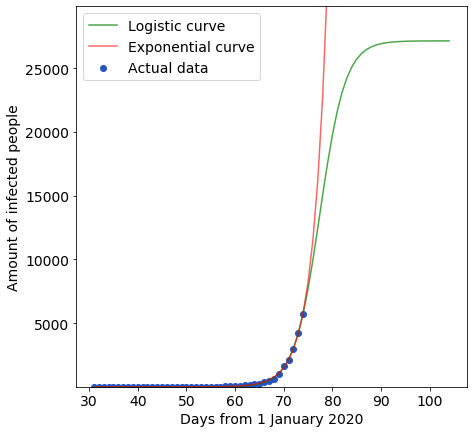

In [100]:
fit_and_plot_a_country('Spain')